# Sliding window causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

The following Nature Review Earth and Environment paper provides an overview of causal inference for time series in general: https://github.com/jakobrunge/tigramite/blob/master/tutorials/Runge_Causal_Inference_for_Time_Series_NREE.pdf

This tutorial explains the function ``PCMCI.run_sliding_window_of`` which is a convenience function that allows to run all PCMCI causal discovery methods on sliding windows across a multivariate time series.

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

## Setup

PCMCI and its variants allow to reconstruct time series graphs from multivariate time series data. An important underlying assumption is *causal stationarity*, i.e., that the conditional independence relations are stationary over time and, hence, the presence and absence of causal links is stationary. Sometimes, one may know that causal relations are only stationary in specific time periods, for example, we may observe different causal relations in summer and winter. This case can be addressed by the masking functionality which is discussed in the corresponding tutorial.

In the sliding window analyis implemented in ``run_sliding_window_of``, on the other hand, we conduct the causal graph estimation separately on a sequence of time windows which is *sled* over the time series. That is, given a ``method``, ``window_step`` $s$ and ``window_length`` $w$, we run the method (e.g., PCMCIplus) sequentially on the samples in each time window $\{\mathbf{X}_t\}_{t=s\cdot i}^{s\cdot i+w-1}$ for $i=0, 1, \ldots$.

In the following we discuss two potential use cases.

## Use case I: Time-varying causal dynamics

In this case we assume that the underlying stochastic process $\mathbf{X}_t=(X^1_t,\ldots,X^N_t)$ has a *time-varying causal structure*. This may affect the functional dependencies, causal parents, and noise distributions. Hence, we assume the following structural causal model (SCM):

\begin{align} \label{eq:causal_model}
X^j_t &= f^j_t\left(\mathcal{P}_t(X^j_t),\,\eta^j_t\right)\quad \eta^j_t\sim \mathcal{D}_t
\end{align}

where $f^j_t$ is some arbitrary function with non-trivial dependencies on its arguments $\mathcal{P}_t(X^j_t)$ and $\eta^j_t$. The latter represents mutually ($i\neq j$) and serially ($t'\neq t$) independent dynamical noise following some distribution $\mathcal{D}_t$. Different from before, all three, $f^j_t$,  $\mathcal{P}_t(X^j_t)$, and $\mathcal{D}_t$ may be *time-dependent* here.

Of course, if this time-dependence is not restricted in some way, then causal relations cannot be identified. In the following example, we consider a *slowly* varying change governed by a slow confounder $U$.

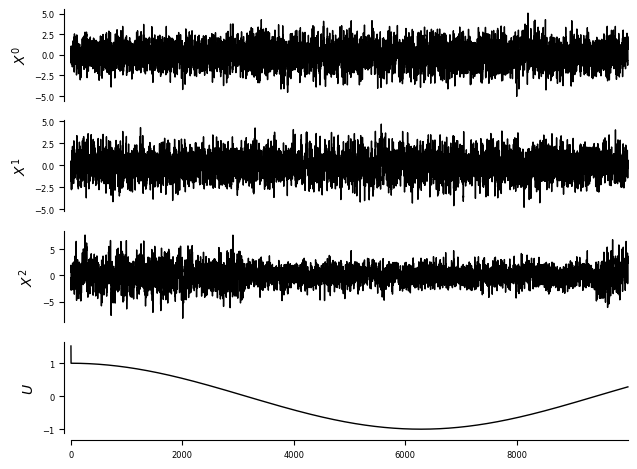

In [2]:
np.random.seed(42)
N = 4
T = 10000
data = np.random.randn(T, N)
datatime = np.arange(T)

# Simple unobserved confounder U that smoothly changes causal relations
U = np.cos(np.arange(T)*0.0005) #+ 0.1*np.random.randn(T)
c = 0.8
for t in range(1, T):
    if U[t] >= 0:
        data[t, 0] += 0.4*data[t-1, 0] 
        data[t, 1] += 0.5*data[t-1, 1] + 0.4*U[t]*data[t-1, 0]
        data[t, 2] += 0.6*data[t-1, 2] + data[t, 0] 
    else:
        data[t, 2] += 0.6*data[t-1, 2]         
        data[t, 0] += 0.4*data[t-1, 0] + 0.4*data[t, 2]
        data[t, 1] += 0.5*data[t-1, 1] + 0.4*U[t]*data[t-1, 0]
    data[t, 3] = U[t]

# Initialize dataframe object, specify variable names
var_names = [r'$X^{%d}$' % j for j in range(N-1) ] + [r'$U$']
dataframe_plot = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe_plot); plt.show()

# For the analysis we use only the observed data
dataframe = pp.DataFrame(data[:,:3], var_names=var_names[:-1])

As you can see from the data-generating process, $U$ changes the strength and sign of the causal link from $X^0_{t-1}\to X^1_t$ and, in addition, the causal direction of the contemporaneous link between $X^0_t$ and $X^2_t$. We assume that we do *not* know the unobserved confounder $U$ and construct the dataframe only from $X^0, X^1, X^2$.

We now run ``run_sliding_window_of`` with ``method='run_pcmciplus'``, ``window_step=10000`` and ``window_length=10000``. Additional arguments to ``'run_pcmciplus'`` are passed using ``method_args``. Of course, the windows may also be chosen to be overlapping.

In [3]:
window_step=1000
window_length=1000
method='run_pcmciplus'
method_args={'tau_min':0, 'tau_max':2, 'pc_alpha':0.01}
conf_lev = 0.95
cond_ind_test = ParCorr(significance='analytic')

# Init
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cond_ind_test,
    verbosity=0)
# Run
results = pcmci.run_sliding_window_of(method=method, 
                                    method_args=method_args, 
                                    window_step=window_step,
                                    window_length=window_length,
                                    conf_lev = conf_lev)



``run_sliding_window_of`` returns a dictionary with entries `'summary_results'` and `'window_results'`. The first one is discussed for the second use case. ``results['window_results']`` now contains the same result entries as the results of a standard PCMCIplus analysis, but each one is a list of results for every sliding window. In the following we focus on the ``graph`` and ``val_matrix`` and visualize them aligned with the time series.

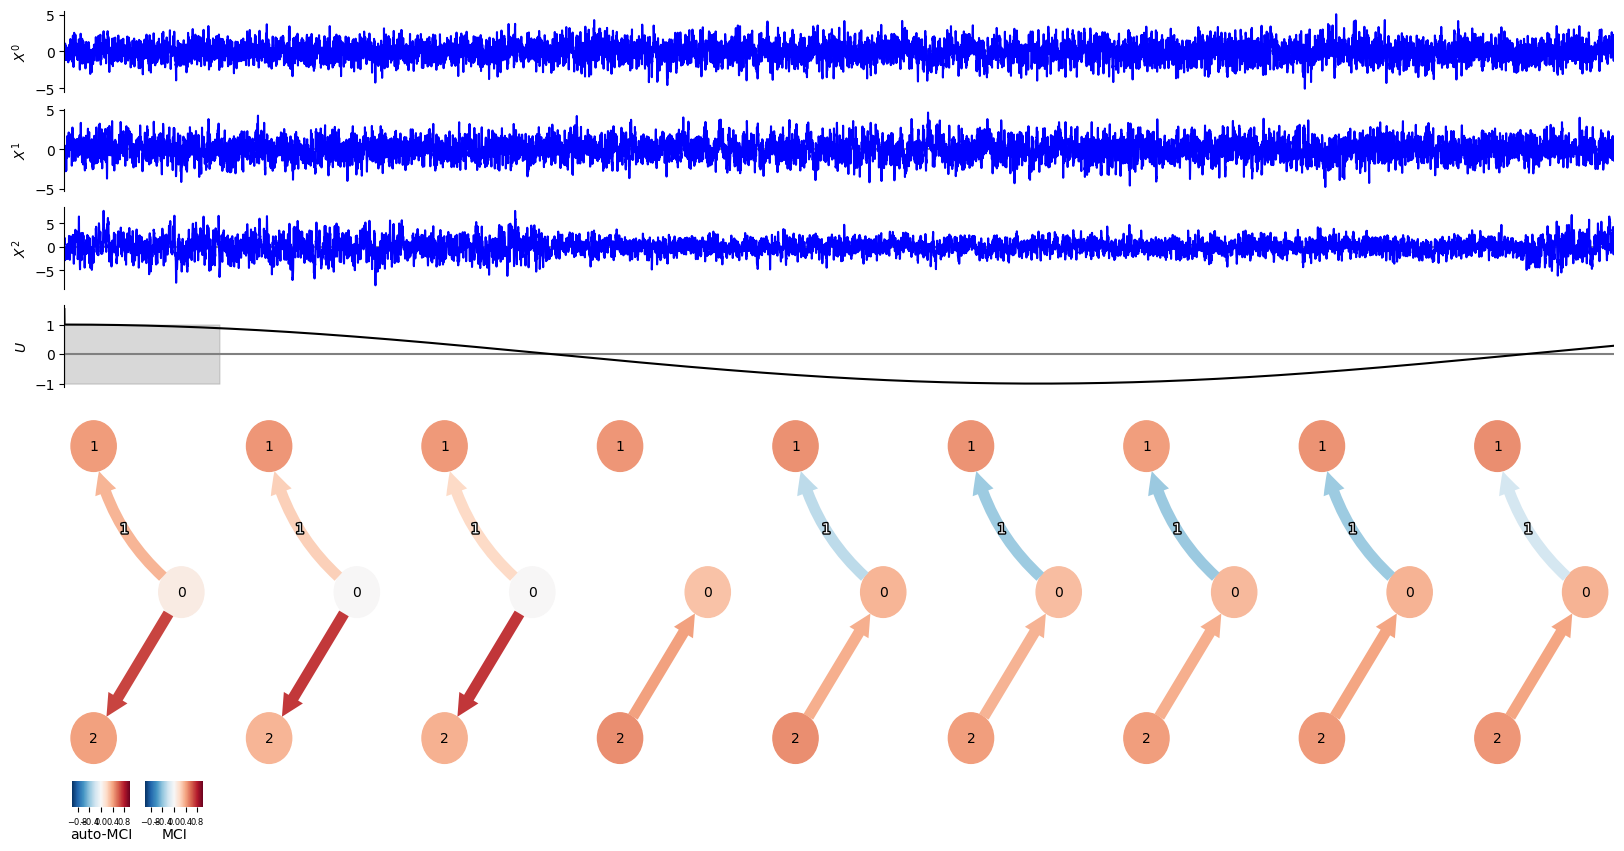

In [4]:
graphs = results['window_results']['graph']
val_matrices = results['window_results']['val_matrix']
n_windows = len(graphs)

mosaic = [['data %s' %j for i in range(n_windows)] for j in range(N)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_windows)])
# print(mosaic)
fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(20, 10))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    if j ==3:
        ax.fill_between(x=datatime, y1=-1, y2=1, where=datatime <= window_length, color='grey', alpha=0.3)
    
    if j == 3: color = 'black'
    else: color = 'blue'
    ax.plot(datatime, data[:,j], color=color)
#     axs['data %s' %j].axis('off') # xaxis.set_ticklabels([])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])

for w in range(n_windows):
    if w == 0: show_colorbar=True
    else: show_colorbar = False
    tp.plot_graph(graphs[w], val_matrix=val_matrices[w], show_colorbar=show_colorbar,
                  fig_ax=(fig, axs['graph %s' %w]))



As you can see, here there are 9 sliding windows (the length is indicated as the grey bar in the $U$-time series. As expected, over time the strength and sign of the causal link from $X^0_{t-1}\to X^1_t$ and, in addition, the causal direction of the contemporaneous link between $X^0_t$ and $X^2_t$ change.

We can also extract the link strength value of the link from $X^0_{t-1}\to X^1_t$ from ``val_matrices``:

Text(0, 0.5, 'Link Strength')

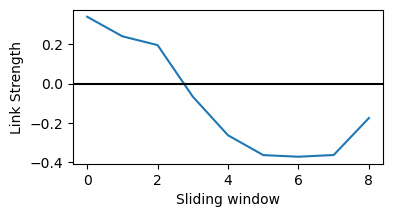

In [5]:
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
ax.plot(list(range(n_windows)), val_matrices[:, 0, 1, 1])
ax.axhline(color='black')
ax.set_xlabel("Sliding window")
ax.set_ylabel("Link Strength")

## Use case II: Stationary causal relations with a slowly varying confounder

In this case we assume that the `SCM` among $\mathbf{X}_t=(X^1_t,\ldots,X^N_t)$ among the $X^i$ is stationary over time, i.e., $f^j$,  $\mathcal{P}(X^j_t)$, and $\mathcal{D}$ are *not* time dependent, but that there is an added external, slowly-varying confounder. (Of course, the true SCM includes this confounder). 

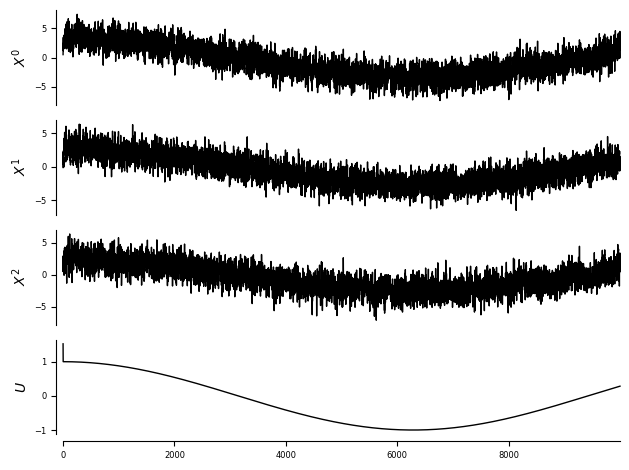

In [11]:
np.random.seed(42)
N = 4
T = 10000
data = np.random.randn(T, N)
datatime = np.arange(T)
# Simple unobserved confounder U that smoothly induces a non-stationarity
U = np.cos(np.arange(T)*0.0005) #+ 0.1*np.random.randn(T)
c = 1.
for t in range(1, T):
    data[t, 2] += 0.6*data[t-1, 2] + c*U[t]
    data[t, 0] += 0.4*data[t-1, 0] + 0.4*data[t, 2] + c*U[t]
    data[t, 1] += 0.5*data[t-1, 1] + 0.1*data[t-1, 0] + c*U[t]
    data[t, 3] = U[t]

# Initialize dataframe object, specify variable names
var_names = [r'$X^{%d}$' % j for j in range(N-1) ] + [r'$U$']
dataframe_plot = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe_plot); plt.show()

# For the analysis we use only the observed data
dataframe = pp.DataFrame(data[:,:3], var_names=var_names[:-1])

We run the analysis both on the whole time series and in sliding windows.

In [12]:
window_step=1000
window_length=1000
method='run_pcmciplus'
method_args={'tau_min':0, 'tau_max':1, 'pc_alpha':0.01}
conf_lev = 0.95
cond_ind_test = ParCorr(significance='analytic')

# Init
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cond_ind_test,
    verbosity=0)
# Run
results = pcmci.run_sliding_window_of(method=method, 
                                    method_args=method_args, 
                                    window_step=window_step,
                                    window_length=window_length,
                                    conf_lev = conf_lev)



The strong unobserved confounding induces a trend in all variables that makes them dependent. Hence, if we analyze the whole time frame, we get an almost fully connected graph.

In [13]:
# results_alldata = pcmci.run_pcmciplus(**method_args)
# tp.plot_graph(graph=results_alldata['graph'], val_matrix=results_alldata['val_matrix']); plt.show()

On the other hand, in each sliding window the unobserved confounder can be assumed constant and, hence, does not lead to a confounding.

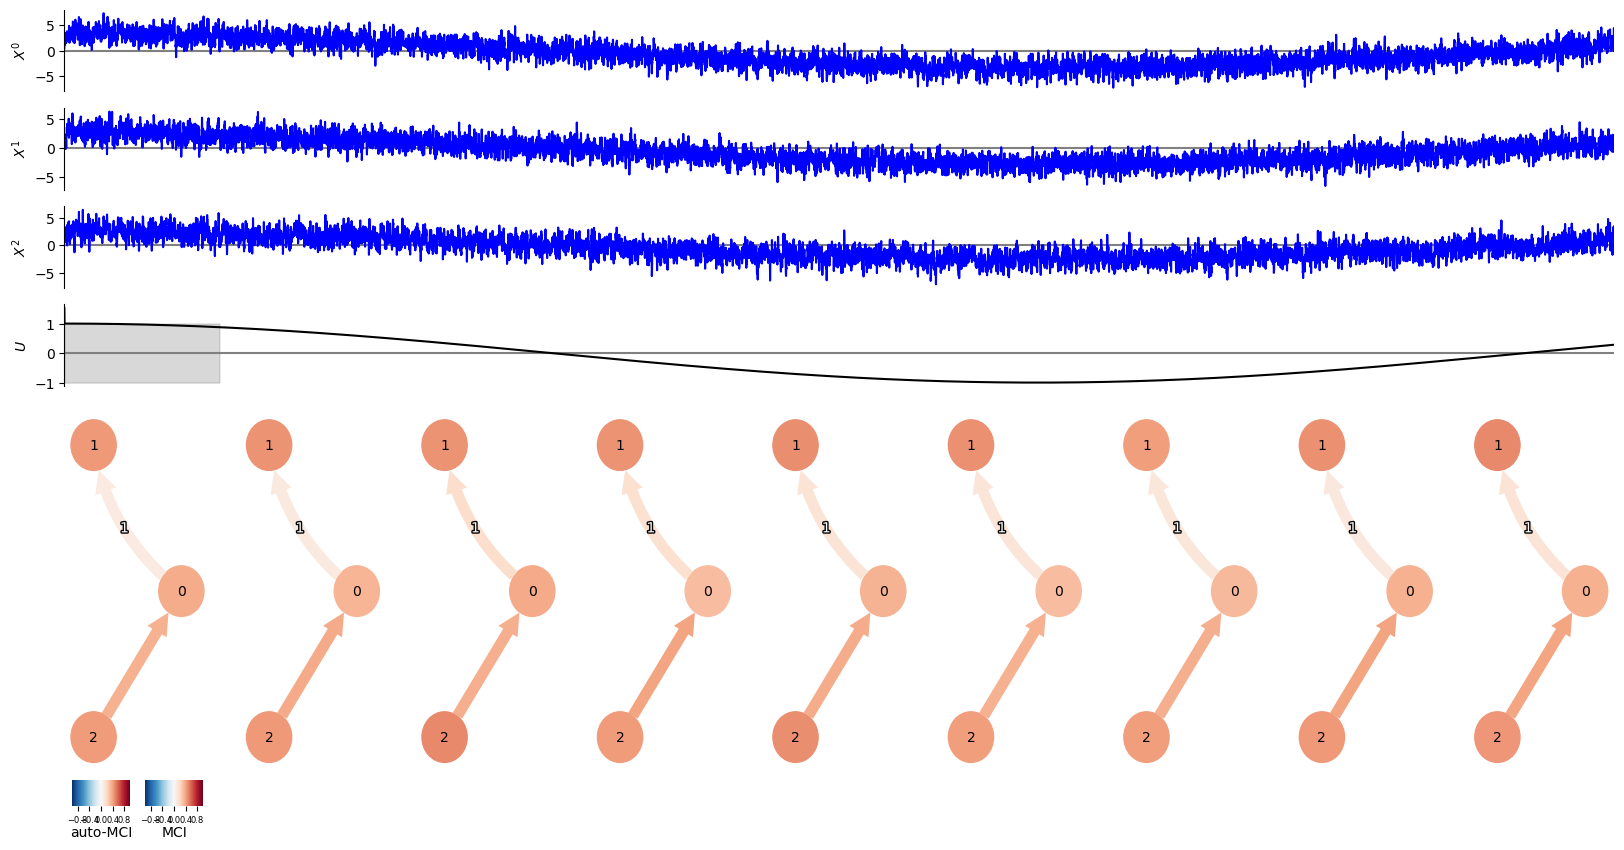

In [14]:
graphs = results['window_results']['graph']
val_matrices = results['window_results']['val_matrix']
n_windows = len(graphs)

mosaic = [['data %s' %j for i in range(n_windows)] for j in range(N)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_windows)])
# print(mosaic)
fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(20, 10))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    if j ==3:
        ax.fill_between(x=datatime, y1=-1, y2=1, where=datatime <= window_length, color='grey', alpha=0.3)
    
    if j == 3: color = 'black'
    else: color = 'blue'
    ax.plot(datatime, data[:,j], color=color)
#     axs['data %s' %j].axis('off') # xaxis.set_ticklabels([])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])

for w in range(n_windows):
    if w == 0: show_colorbar=True
    else: show_colorbar = False
    tp.plot_graph(graphs[w], val_matrix=val_matrices[w], show_colorbar=show_colorbar,
                  fig_ax=(fig, axs['graph %s' %w]))



Now the graph is rather stationary over time. With this assumption of an effectively stationary SCM, we may also consider summary statistics in ``'summary_results'``. ``'most_frequent_links'`` contains a graph where each entry contains the link that occurs most frequently among the sliding windows, including the absence of a link ``""``. ``'link_frequency'`` contains the fraction of sliding windows where that link occurs. Finally, ``'val_matrix_mean'`` contains the averaged test statistic values over all time windows. These three features can be visualized using ``plot_graph``.

__Note:__ The test statistic values (e.g., partial correlation) may give a qualitative intuition of the `strength` of a dependency, but for a proper causal effect analysis please refer to the ``CausalEffects`` class.

most_frequent_links
[[['' '-->']
  ['' '-->']
  ['<--' '']]

 [['' '']
  ['' '-->']
  ['' '']]

 [['-->' '']
  ['' '']
  ['' '-->']]]
link_frequency
[[[1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]]]


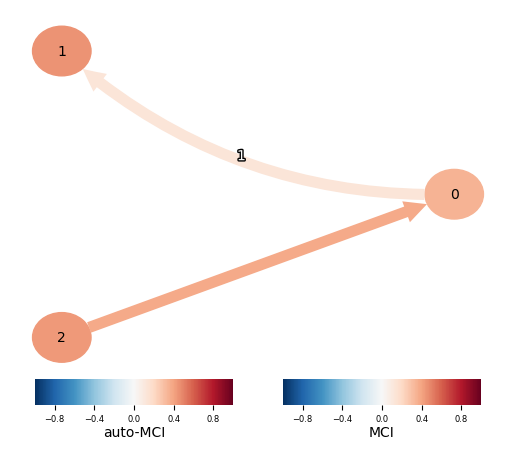

In [15]:
tp.plot_graph(graph=results['summary_results']['most_frequent_links'], 
              val_matrix=results['summary_results']['val_matrix_mean'],
             link_width=results['summary_results']['link_frequency'])
print('most_frequent_links')
print(results['summary_results']['most_frequent_links'].squeeze())
print('link_frequency')
print(results['summary_results']['link_frequency'].squeeze())

Here the link from $X^0 \to X^1$ is weak and, hence, only detected in a smaller fraction of the windows.